In [1]:
import numpy as np
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.utils.mappings import kerrecceq_forward_map
from few.utils.utility import get_separatrix

fewFlux = KerrEccEqFlux()

Importing flux data from Black Hole Perturbation Club. https://sites.google.com/view/bhpc1996/data . Corresponds to fluxes from https://arxiv.org/abs/2008.13554 . Fluxes saved in this repo. Accessed 23/03/2025.

From readme...
dIdt_qXXXX.dat contain:
$(a, p, e,\theta_{inc}, E, L_z, C, \frac{dE^{\infty}}{dt}, \frac{d L_z^{\infty}}{dt},\frac{d C^{\infty}}{dt},\frac{d E^{H}}{dt},\frac{d L_z^{H}}{dt},\frac{d C^{H}}{dt},\frac{dp^{\infty}}{dt},\frac{d e^{\infty}}{dt},\frac{d\theta_{inc}^{\infty}}{dt}, \frac{dp^{H}}{dt},\frac{d e^{H}}{dt},\frac{d\theta_{inc}^{H}}{dt},l_{max},\Delta E^{\infty},\Delta E^{H})$
in each line with:
$\Delta E^{\infty,H}: (\frac{dE^{\infty,H}}{dt})_{\ell=l_{max}}/(\frac{dE^{\infty,H}}{dt})$

In general, $l_{max}=25$ or $l_{max}<25$ with $\Delta E^{\infty,H}<10^{-6}$. In some cases, however, we have $l_{max}<25$
with $\Delta E^{\infty,H}>10^{-6}$ because of failure in computing "renormalized angular 
momentum".

In [2]:
data_a0p9pro = np.loadtxt('pert_club_flux_data/dIdt_q0.90inc0.dat')
data_a0p7pro = np.loadtxt('pert_club_flux_data/dIdt_q0.70inc0.dat')
data_a0p5pro = np.loadtxt('pert_club_flux_data/dIdt_q0.50inc0.dat')
data_a0p3pro = np.loadtxt('pert_club_flux_data/dIdt_q0.30inc0.dat')
data_a0p1pro = np.loadtxt('pert_club_flux_data/dIdt_q0.10inc0.dat')

data_a0p9ret = np.loadtxt('pert_club_flux_data/dIdt_q-0.90inc0.dat')
data_a0p7ret = np.loadtxt('pert_club_flux_data/dIdt_q-0.70inc0.dat')
data_a0p5ret = np.loadtxt('pert_club_flux_data/dIdt_q-0.50inc0.dat')
data_a0p3ret = np.loadtxt('pert_club_flux_data/dIdt_q-0.30inc0.dat')
data_a0p1ret = np.loadtxt('pert_club_flux_data/dIdt_q-0.10inc0.dat')

In [3]:
def pdotedotcompare(a, x, data):
    M = 1 #1e6
    mu = 1 # 1e1
    fewFlux.add_fixed_parameters(M, mu, a)
    
    length=data.shape[0]

    pepdotedotvals= np.zeros((length,12))
    for i in range(length):
        
        p=data[i][1]
        e=data[i][2]

        lmax=data[i][-3]
        DeltaEinf=data[i][-2]
        DeltaEh=data[i][-1]
        
        pLSO=get_separatrix(a,e,x)

        u, w, _, z, in_region_A = kerrecceq_forward_map(a*x, p, e, 1.0, pLSO, kind="flux")
 
        if w < 0 or w > 1 + 1e-8:
            
            pepdotedotvals[i][0]=p #Store p value for reference and move on
            pepdotedotvals[i][1]=e #Store e value for reference and move on
            pepdotedotvals[i][2]=(mu/M)*(data[i][13]+data[i][16]) #Store total pdot value
            pepdotedotvals[i][3]=(mu/M)*(data[i][14]+data[i][17]) #Store total edot value

        else:
            
            pdot, edot, xIdot, Omega_phi, Omega_theta, Omega_r = fewFlux([p, e, x])

            pepdotedotvals[i][0]=p #Store p value for reference and move on
            pepdotedotvals[i][1]=e #Store e value for reference and move on
        
            pepdotedotvals[i][2]=(mu/M)*(data[i][13]+data[i][16]) #Store total pdot value
            pepdotedotvals[i][3]=(mu/M)*(data[i][14]+data[i][17]) #Store total edot value

            pepdotedotvals[i][4]= pdot #Store total pdot value from FEW
            pepdotedotvals[i][5]= edot #Store total edot value from FEW

            pepdotedotvals[i][6] = np.log10(abs(1 - pdot/pepdotedotvals[i][2])) #Store log10 of pdot relative diff
            pepdotedotvals[i][7] = np.log10(abs(1 - edot/pepdotedotvals[i][3])) #Store log10 of edot relative diff

            pepdotedotvals[i][8] = lmax #Store BHPC's lmax for later reference
            pepdotedotvals[i][9] = np.log10(abs(DeltaEinf)) #Store BHPC's DeltaEinf for later reference on log scale
            pepdotedotvals[i][10] = np.log10(abs(DeltaEh)) #Store BHPC's DeltaEh for later reference on log scale

            pepdotedotvals[i][11] = p-pLSO #Store as distance from separatrix for later.


    #Now filter out the entries outside of the domain of the interpolant by deleting rows where the last seven entries are zero
    filtered_array = pepdotedotvals[~np.all(pepdotedotvals[:, -8:] == 0, axis=1)]

    return filtered_array


In [4]:
compare_a0p9pro = pdotedotcompare(0.9, 1, data_a0p9pro)
compare_a0p7pro = pdotedotcompare(0.7, 1, data_a0p7pro)
compare_a0p5pro = pdotedotcompare(0.5, 1, data_a0p5pro)
compare_a0p3pro = pdotedotcompare(0.7, 1, data_a0p3pro)
compare_a0p1pro = pdotedotcompare(0.5, 1, data_a0p1pro)

In [5]:
compare_a0p9ret = pdotedotcompare(0.9, -1, data_a0p9ret)
compare_a0p7ret = pdotedotcompare(0.7, -1, data_a0p7ret)
compare_a0p5ret = pdotedotcompare(0.5, -1, data_a0p5ret)
compare_a0p3ret = pdotedotcompare(0.7, -1, data_a0p3ret)
compare_a0p1ret = pdotedotcompare(0.5, -1, data_a0p1ret)

In [6]:
import matplotlib.pyplot as plt

def plot_heatmaps(array,a,x):

    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = ["Computer Modern"]

    label_fontsize = 14
    tick_fontsize = 14
    title_fontsize = 16

    # Extract the p, e, z1=pdot rel diff, and z2=edot rel diff values from the array
    p = array[:, 0]
    e = array[:, 1]
    z1 = array[:, 6]
    z2 = array[:, 7]
    
    lmax=array[:,-4]
    deltaEinf=array[:,-3]
    deltaEh=array[:,-2]

    #Change x-axis from p to p-psep
    deltap=deltaEh=array[:,-1]

    
    # Create a figure with four subplots
    fig, axes = plt.subplots(2, 2, figsize=(10,10))

    # Plot the pdot rel diff using scatter plot
    scatter1 = axes[0,0].scatter(deltap, e, c=z1, cmap='plasma',rasterized=True)
    axes[0,0].set_title(r'$ \log_{10} \left(| 1 - f_p^{FEW}/ f_p^{BHPC} | \right)$', fontsize=title_fontsize)
    axes[0,0].set_xlabel(r'Adjusted semilatus rectum $(p-p_{LSO})$', fontsize=label_fontsize)
    axes[0,0].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[0,0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter1, ax=axes[0,0])

    # Plot the edot rel diff using scatter plot
    scatter2 = axes[0,1].scatter(deltap, e, c=z2, cmap='plasma',rasterized=True)
    axes[0,1].set_title(r'$ \log_{10} \left(| 1 - f_e^{FEW}/ f_e^{BHPC} | \right)$', fontsize=title_fontsize)
    axes[0,1].set_xlabel(r'Adjusted semilatus rectum $(p-p_{LSO})$', fontsize=label_fontsize)
    axes[0,1].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[0,1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatter2, ax=axes[0,1])

    # Plot the corresponding lmax
    scatterl = axes[1,0].scatter(deltap, e, c=lmax, cmap='plasma',rasterized=True)
    axes[1,0].set_title(r'$  \ell_{max}$', fontsize=title_fontsize)
    axes[1,0].set_xlabel(r'Adjusted semilatus rectum $(p-p_{LSO})$', fontsize=label_fontsize)
    axes[1,0].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[1,0].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatterl, ax=axes[1,0])

    # Plot the corresponding Delta E inf, assuming horizon flux subdominant.
    scatterE = axes[1,1].scatter(deltap, e, c=deltaEinf, cmap='plasma',rasterized=True)
    axes[1,1].set_title(r'$ \log_{10} \left(\Delta E_{\infty}\right)$', fontsize=title_fontsize)
    axes[1,1].set_xlabel(r'Adjusted semilatus rectum $(p-p_{LSO})$', fontsize=label_fontsize)
    axes[1,1].set_ylabel(r'Eccentricity $(e)$', fontsize=label_fontsize)
    
    axes[1,1].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    fig.colorbar(scatterE, ax=axes[1,1])

    # Display the plots
    plt.tight_layout()

    if x==-1:
        figurename=f'FluxComparisonBHPC_{a}_retro.pdf'
    elif x==1:
        figurename=f'FluxComparisonBHPC_{a}_pro.pdf'
    else:
        Print("Input should be x=1 for prograde or x=-1 for retrograde")

    plt.savefig(figurename)
    plt.show()  

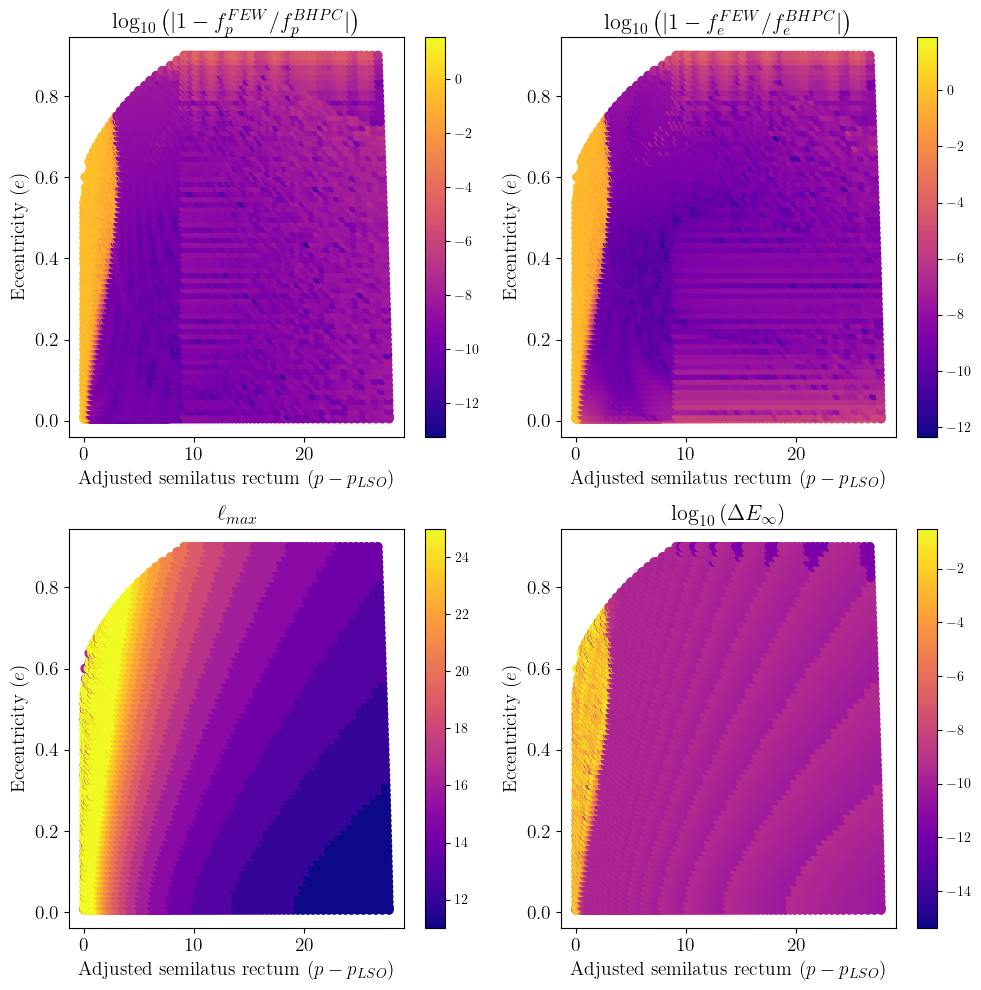

In [7]:
plot_heatmaps(compare_a0p9pro,0.9,1)

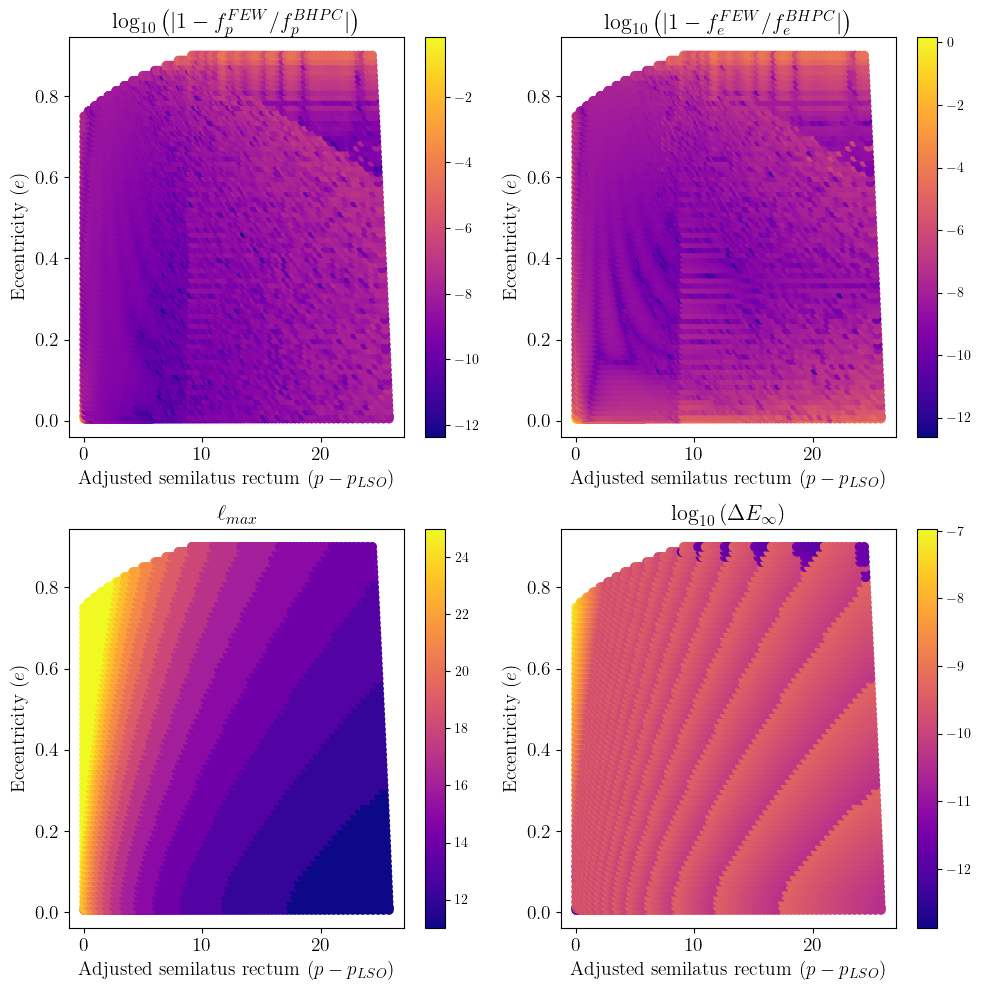

In [10]:
plot_heatmaps(compare_a0p5pro,0.5,1)

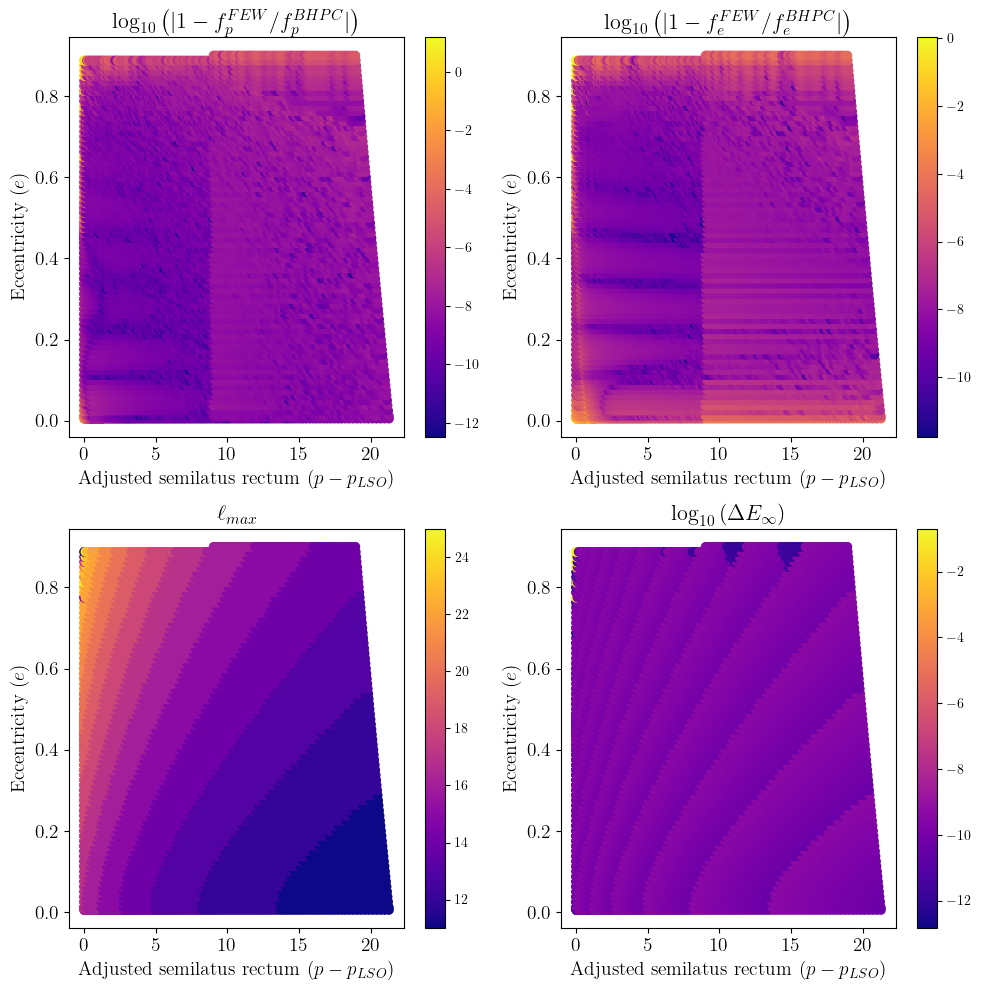

In [9]:
plot_heatmaps(compare_a0p9ret,0.9,-1)